In [42]:
import os
import json

In [2]:
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

In [3]:
#To upload the GTSDB.json file
upload()

Saving GTSDB.json to GTSDB.json
saved file GTSDB.json


In [4]:
os.listdir()

['.config', 'GTSDB.json', 'drive', 'sample_data']

In [5]:
with open('GTSDB.json') as f:
    data = json.load(f)

In [6]:
len(data['output']['frames'])

898

In [7]:
data['output']['frames'][0].keys()

dict_keys(['frame_number', 'RoIs', 'signs'])

In [8]:
data['output']['frames'][0]['signs']

[{'class': 'pg',
  'coordinates': [976, 334, 49, 54],
  'detection_confidence': 0.917523}]

In [43]:
home_dir = os.getcwd()

In [44]:
from zipfile import ZipFile
  
# specifying the zip file name
# file_name = 'drive/MyDrive/FullIJCNN2013.zip'
directory = home_dir + '/YOLOv3-GTSDB' ##Folder NAME
dataset_path = '/content/drive/MyDrive/FullIJCNN2013.zip'  ## Change the path if on local machine
  
# opening the zip file in READ mode
with ZipFile(dataset_path, 'r') as zip:
    # extracting all the files
    print('Extracting the contents now...')
    zip.extractall(directory)
    print('Done!')

Extracting the contents now...
Done!


In [12]:
import numpy as np
txt = np.genfromtxt(directory + '/FullIJCNN2013/gt.txt', delimiter =';', dtype= None,encoding=None)
txt
#Creating a dictionary with image names as key and annotations as value
image_info ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    # clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in image_info):
        image_info[img_name].append(target)
    else:
        image_info[img_name] = [target]
print(image_info['00001.ppm'])
print("Number of Images: " + str(len(image_info)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 741


In [45]:
def extract_signs(data, sign_class, confidence_threshold = 0):
    frames = {}
    for frame in data['output']['frames']:
        for sign in frame['signs']:
            if sign_class == sign['class']:
                if (frame['frame_number'] in frames):
                    frames[frame["frame_number"]].append(sign)
                else:
                    frames[frame["frame_number"]] = [sign]
    return frames

pn_signs = extract_signs(data, sign_class="pn")
pne_signs = extract_signs(data, sign_class="pne")
ps_signs = extract_signs(data, sign_class="ps")
pg_signs = extract_signs(data, "pg")
redroundsign_signs = extract_signs(data, "RedRoundSign")

def count_total_boxes(data):
    counter = 0
    for frame in data['output']['frames']:
        for sign in frame['signs']:
            counter += 1
            
    return counter

def count_sign_boxes(data):
    counter = 0
    for image, signs in data.items():
        counter += len(signs)

    return counter

for image_number in pn_signs.keys():
    for sign in pn_signs[image_number]:
        print(image_number, sign)

classes_43 = ['00261.ppm', '00304.ppm', '00544.ppm', '00545.ppm', '00575.ppm', '00777.ppm', '00813.ppm', '00841.ppm']
classes_44 = ['00259.ppm', '00274.ppm', '00555.ppm', '00673.ppm', '00697.ppm']

for image_number in pn_signs.keys():
    for sign in pn_signs[image_number]:
        sign['class'] = 43 if image_number in classes_43 else 44

In [15]:
# Method to convert YOLO coordinates back to normal format
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    x1, y1 = int(box[0]), int(box[1])
    x2, y2 = int((box[0] + box[2])), int((box[1] + box[3]))
    return x1, y1, x2, y2

for image_number in pn_signs.keys():
    for sign in pn_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in image_info):
            image_info[image_number].append([x1, y1, x2, y2, sign['class']])
        else:
            image_info[image_number] = [[x1, y1, x2, y2, sign['class']]]  

In [13]:
import shutil
from PIL import Image

data_dir = directory
train_img_dir = data_dir + '/FullIJCNN2013/'
image_dir_jpg = (data_dir + '/GTSDB_jpg/')
if os.path.exists(image_dir_jpg):
    shutil.rmtree(image_dir_jpg)
os.makedirs(image_dir_jpg)

# Convert ppm files to jpeg files and store them in a folder
for file, values in image_info.items():
    ppm_file = train_img_dir + file
    target =  image_dir_jpg + file
    if ppm_file[-3:] == "ppm":
        # img_path = os.path.join(train_img_dir, img_name)
        img = Image.open(ppm_file)
        jpg_path = target[:-3]+'jpg'
        # print(jpg_path)
        img.save(jpg_path)
    else:
        shutil.copyfile(ppm_file, target)

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def draw_boxes(img, boxes, color = (0,255,0)):
    image= np.array(img)
    for box in boxes:
        # x1, y1, x2, y2 = from_yolo_to_cor(box, shape)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 3)
    plt.figure(figsize = (12,12))
    plt.imshow(image, interpolation='nearest')
    # plt.imshow(image, figsize=(12,12))

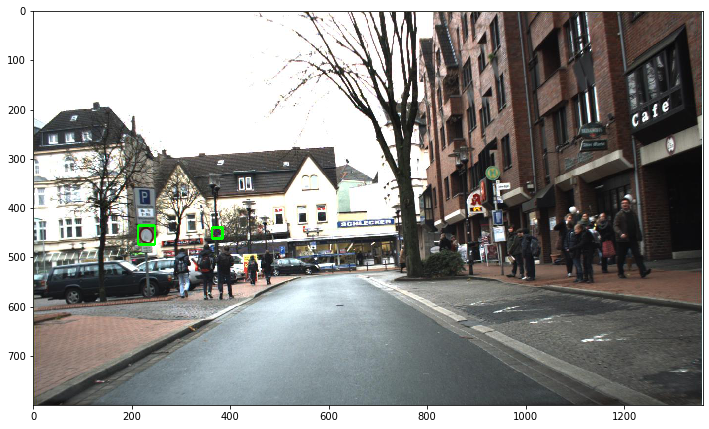

In [17]:
img = Image.open(data_dir + '/GTSDB_jpg/00545.jpg')
# plt.imshow(img)
draw_boxes(img, image_info['00545.ppm'])

In [18]:
image_info = sorted(image_info.items(), key = lambda item: str(item[0].replace(".ppm","")))
image_info = {k:v for k, v in image_info}

In [19]:
image_info

{'00000.ppm': [[774, 411, 815, 446, 11]],
 '00001.ppm': [[983, 388, 1024, 432, 40],
  [386, 494, 442, 552, 38],
  [973, 335, 1031, 390, 13]],
 '00002.ppm': [[892, 476, 1006, 592, 39]],
 '00003.ppm': [[742, 443, 765, 466, 4],
  [742, 466, 764, 489, 9],
  [737, 412, 769, 443, 21]],
 '00004.ppm': [[898, 342, 967, 409, 21], [906, 407, 955, 459, 2]],
 '00005.ppm': [[1172, 164, 1284, 278, 9]],
 '00006.ppm': [[926, 350, 989, 414, 2]],
 '00007.ppm': [[825, 406, 864, 445, 9]],
 '00008.ppm': [[785, 460, 811, 486, 2], [779, 424, 816, 461, 12]],
 '00009.ppm': [[925, 466, 949, 490, 4]],
 '00010.ppm': [[1193, 358, 1269, 436, 12]],
 '00011.ppm': [[720, 338, 770, 398, 1], [710, 265, 780, 342, 21]],
 '00012.ppm': [[979, 364, 1034, 418, 1]],
 '00013.ppm': [[1043, 281, 1120, 356, 2]],
 '00014.ppm': [[712, 492, 732, 511, 21]],
 '00015.ppm': [[770, 426, 808, 462, 25]],
 '00016.ppm': [[901, 421, 959, 478, 12]],
 '00017.ppm': [[908, 302, 1031, 408, 30], [575, 495, 598, 515, 11]],
 '00018.ppm': [[950, 455, 98

In [20]:
with open(home_dir + '/gt_new.txt', "w") as outfile:
    for file in image_info:
        for box in image_info[file]:
            # box_coords = convert_labels(data_dir + '/GTSDB_jpg/{}'.format(file).replace('ppm', 'jpg'), box[0], box[1], box[2], box[3])
            line = '{};{};{};{};{};{}'.format(file, box[0], box[1], box[2], box[3], box[4])
            outfile.write(line)
            outfile.write('\n')
    outfile.close()

**Question 2**

In [21]:
pn_signs = extract_signs(data, sign_class="pn")
pne_signs = extract_signs(data, sign_class="pne")
ps_signs = extract_signs(data, sign_class="ps")
pg_signs = extract_signs(data, "pg")
redroundsign_signs = extract_signs(data, "RedRoundSign")

In [23]:
new_image_info = {}

for image_number in redroundsign_signs.keys():
    for sign in redroundsign_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in new_image_info):
            new_image_info[image_number].append([x1, y1, x2, y2, sign['detection_confidence'],sign['class']])
        else:
            new_image_info[image_number] = [[x1, y1, x2, y2, sign['detection_confidence'], sign['class']]]
for image_number in pg_signs.keys():
    for sign in pg_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in new_image_info):
            new_image_info[image_number].append([x1, y1, x2, y2,sign['detection_confidence'], sign['class']])
        else:
            new_image_info[image_number] = [[x1, y1, x2, y2,sign['detection_confidence'], sign['class']]] 
for image_number in ps_signs.keys():
    for sign in ps_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in new_image_info):
            new_image_info[image_number].append([x1, y1, x2, y2, sign['detection_confidence'],sign['class']])
        else:
            new_image_info[image_number] = [[x1, y1, x2, y2, sign['detection_confidence'],sign['class']]] 
for image_number in pne_signs.keys():
    for sign in pne_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in new_image_info):
            new_image_info[image_number].append([x1, y1, x2, y2, sign['detection_confidence'],sign['class']])
        else:
            new_image_info[image_number] = [[x1, y1, x2, y2, sign['detection_confidence'],sign['class']]] 
for image_number in pn_signs.keys():
    for sign in pn_signs[image_number]:
        x1, y1, x2, y2 = from_yolo_to_cor(sign['coordinates'], (800,1360,3))
        if(image_number in new_image_info):
            new_image_info[image_number].append([x1, y1, x2, y2, sign['detection_confidence'],sign['class']])
        else:
            new_image_info[image_number] = [[x1, y1, x2, y2, sign['detection_confidence'],sign['class']]] 

In [25]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
classes = [0,1,2,3,4,5,7,8,9,10,15,16,13,14,17,43,44]
filtered_image_info = {}
for img, val in image_info.items():
  for sign in val:
    if sign[-1] in classes:
      if (img in filtered_image_info):
        filtered_image_info[img].append(sign)
      else:
        filtered_image_info[img] = [sign]

In [27]:
counter = 0
for item, val in filtered_image_info.items():
  for sign in val:
    counter +=1

print(counter)

715


In [29]:
for image_number in filtered_image_info.keys():
    for sign in filtered_image_info[image_number]:
        if (sign[-1] in [0,1,2,3,4,5,7,8,9,10,15,16]):
            sign[-1] = 'RedRoundSign'
        elif (sign[-1] in [13]):
            sign[-1] = 'pg'
        elif (sign[-1] in [14]):
            sign[-1] = 'ps'
        elif (sign[-1] in [17]):
            sign[-1] = 'pne'
        elif (sign[-1] in [43, 44]):
            sign[-1] = 'pn'

In [31]:
counter_gt = 0
counter_pred = 0

for item, val in filtered_image_info.items():
  for sign in val:
    if sign[-1] == 'RedRoundSign':
      counter_gt +=1

for item, val in new_image_info.items():
  for sign in val:
    if sign[-1] == 'RedRoundSign':
      counter_pred +=1

print(counter_gt)
print(counter_pred)

557
526


In [35]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for sign in val:
            if sign[4] not in model_score.keys():
                model_score[sign[4]]=[img_id]
            else:
                model_score[sign[4]].append(img_id)
    return model_score

In [36]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox[:4]
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox[:4]
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
    #if the GT bbox and predicted BBox do not overlap then iou=0
    if (x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        return 0.0
    if (y_bottomright_gt< y_topleft_p):  
      # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        return 0.0
    if (x_topleft_gt> x_bottomright_p): 
      # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        return 0.0
    if (y_topleft_gt> y_bottomright_p): 
      # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [37]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [38]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [39]:
def  get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    model_scores = get_model_scores(pred_boxes)
    sorted_model_scores= sorted(model_scores.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    pred_bb = {}
    for img_id in pred_boxes.keys():
        for sign in pred_boxes[img_id]:
            if (img_id in pred_bb):
                pred_bb[img_id]['scores'].append(sign[4])
                pred_bb[img_id]['boxes'].append(sign[:4])
            else:
                pred_bb[img_id] = {'scores': [sign[4]], 'boxes': [sign[:4]]}
    # print(pred_bb)

    for img_id in pred_bb.keys():
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
        # print(pred_bb[img_id])
        # arg_sort = np.argsort(pred_bb[img_id][4])
        # pred_bb[img_id][4] = np.array(pred_bb[img_id][4])[arg_sort].tolist()
        # pred_bb[img_id][:4] = np.array(pred_bb[img_id][:4])[arg_sort].tolist() 
    
    pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        # print("Model score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]

        for img_id in img_ids:

            gt_boxes_img = gt_boxes[img_id] if img_id in gt_boxes else []
            # if not img_id in pred_boxes_pruned: pred_boxes_pruned[img_id] = {'scores' = []}
            # box_scores = pred_boxes_pruned[img_id]['scores'] if pred_boxes_pruned[img_id] else []
            # # start_idx = 0
            # # for score in box_scores:
            # #     if score <= model_score_thr:
            # #         pred_boxes_pruned[img_id]
            # #         start_idx += 1
            # #     else:
            # #         break 
            # Remove boxes, scores of lower than threshold scores:
            # pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            # pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]
            # Recalculate image results for this image
            # print(img_id)
            boxes = pred_boxes_pruned[img_id]['boxes'] if img_id in pred_boxes_pruned else []
            img_results[img_id] = get_single_image_results(gt_boxes_img,boxes, iou_thr=0.5)
        
        # calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            # print(recalls,"Recall")
            # print(recall_level,"Recall Level")
            # print(args, "Args")
            # print(prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [40]:
results = (get_avg_precision_at_iou(filtered_image_info, new_image_info))

In [41]:
results['avg_prec']

0.8942364824717765